# Tests for Inhibition Curve Fits

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
from brian2 import *

In [62]:
# functions for plotting
def plot_output_colored(t, v, u, I, save_fig=False, file_name='test.png'):
    fig, axes = plt.subplots(4, sharey=True, figsize=(12, 12))
    
    axes[0].plot(t, v, label='v')
    axes[0].plot(t, u, label='u')
    axes[0].plot(t, I, label='I')
    axes[0].axhline(30, ls='-', c='C3', lw=2, label='v=30')
    axes[0].set_xlabel('Time (ms)')
    axes[0].set_ylabel('v, u, I')
    axes[0].set_title('Trimodal')
    axes[0].legend()
    
    axes[1].plot(t, v, label='v')
    axes[1].plot(t, u, label='u')
    axes[1].plot(t, I, label='I')
    axes[1].axhline(30, ls='-', c='C3', lw=2, label='v=30')
    axes[1].set_xlim([1000, 2000])
    axes[1].set_xlabel('Time (ms)')
    axes[1].set_ylabel('v, u, I')
    axes[1].set_title('Tonic')
    axes[1].legend()
    
    axes[2].plot(t, v, label='v')
    axes[2].plot(t, u, label='u')
    axes[2].plot(t, I, label='I')
    axes[2].axhline(30, ls='-', c='C3', lw=2, label='v=30')
    axes[2].set_xlim([7000, 8000])
    axes[2].set_xlabel('Time (ms)')
    axes[2].set_ylabel('v, u, I')
    axes[2].set_title('Burst')
    axes[2].legend()
    
    axes[3].plot(t, v, label='v')
    axes[3].plot(t, u, label='u')
    axes[3].plot(t, I, label='I')
    axes[3].axhline(30, ls='-', c='C3', lw=2, label='v=30')
    axes[3].set_xlim([13000, 14000])
    axes[3].set_xlabel('Time (ms)')
    axes[3].set_ylabel('v, u, I')
    axes[3].set_title('Quiescent')
    axes[3].legend()
    
    fig.tight_layout()
    
    if save_fig:
        plt.savefig('outputs/' + file_name, bbox_inches='tight')
        plt.close(fig)
    else:
        plt.show()
    
    
def plot_output(t, v, u, save_fig=False, file_name='test.png'):
    fig, axes = plt.subplots(4, sharey=True, figsize=(12, 12))
    
    axes[0].plot(t, v, 'k-', label='v')
    axes[0].plot(t, u, 'k:', label='u')
    axes[0].set_xlabel('Time (ms)')
    axes[0].set_ylabel('v, u')
    axes[0].set_title('Trimodal')
    axes[0].legend()
    
    axes[1].plot(t, v, 'k-', label='v')
    axes[1].plot(t, u, 'k:', label='u')
    axes[1].set_xlim([1000, 2000])
    axes[1].set_xlabel('Time (ms)')
    axes[1].set_ylabel('v, u')
    axes[1].set_title('Tonic')
    axes[1].legend()
    
    axes[2].plot(t, v, 'k-', label='v')
    axes[2].plot(t, u, 'k:', label='u')
    axes[2].set_xlim([7000, 8000])
    axes[2].set_xlabel('Time (ms)')
    axes[2].set_ylabel('v, u')
    axes[2].set_title('Burst')
    axes[2].legend()
    
    axes[3].plot(t, v, 'k-', label='v')
    axes[3].plot(t, u, 'k:', label='u')
    axes[3].set_xlim([13000, 14000])
    axes[3].set_xlabel('Time (ms)')
    axes[3].set_ylabel('v, u')
    axes[3].set_title('Quiescent')
    axes[3].legend()
    
    fig.tight_layout()
    
    if save_fig:
        plt.savefig('outputs/' + file_name, bbox_inches='tight')
        plt.close(fig)
    else:
        plt.show()
    
    
def plot_output_simple(t, v, u, save_fig=False, file_name='test.png'):
    plt.figure(figsize=(12, 4))
    plt.plot(t, v, 'k-', label='v')
    plt.plot(t, u, 'k:', label='u')
    plt.xlabel('Time (ms)')
    plt.ylabel('v, u')
    plt.title('Trimodal')
    plt.legend()
    
    if save_fig:
        plt.savefig('outputs/' + file_name, bbox_inches='tight')
        plt.close()
    else:
        plt.show()
    
    

### Alcohol Inhibition (Complex, Full)

In [3]:
# total run duration 90s
# desired quiescent 10s
# desired bimodal 25s
# desired tonic 15s

def IZH_inh_complex(
    fI='int(t>100*ms)*10', 
    V=-65, 
    tau=0.25, 
    duration_t=5000,
    duration_b=7000,
    duration_q=8000,
    plot_colored = False, #True,
    e = 0, 
    e_max = 0.45,
    R_a = 1,
    R_b = 1,
    R_I = 1,
    save_output = False,
    output_file = 'test.png',
):
        
    defaultclock.dt = tau*ms
    tau = tau/ms
    inhibition_a = 1 - R_a*(e/e_max)
    inhibition_b = 1 - R_b*(e/e_max)
    inhibition_I = 1 - R_I*(e/e_max)
    
    eqs = '''
    dv/dt = int(t>duration/10)*tau*(0.04*v**2+5*v+140-u+(inhibition_I*I)) : 1
    du/dt = int(t>duration/10)*tau*(inhibition_a*a)*((inhibition_b*b)*v-u) : 1
    I : 1
    '''

    # Create a NeuronGroup with one neuron using previous equations
    G = NeuronGroup(1, eqs, threshold='v>=30', reset='v=c; u+=d', method='euler')
    G.v = V
    G.u = 0.2*V
    
    M = StateMonitor(G, ('v', 'u', 'I'), record=0)
    
    @network_operation(dt=1*ms)
    def change_I():
        G.I = fI
    
    for i in range(4):
        print(f'Bimodal pattern {i+1}')
        
        print('Running tonic period...')
        a = 0.02
        b = 0.2
        c = -65
        d = 0.5 # ISI_tonic = 30ms
        duration = duration_t*ms
        run(duration)

        print('Running burst period...')
        a = 0.035
        b = 0.3
        c = -50
        d = 2.4 # duration_burst = 50 to 100ms, rest_burst = 10ms
        duration = duration_b*ms
        run(duration)

        print('Running quiescent period...')
        a = 0
        b = 0
        c = -65
        d = 2
        duration = duration_q*ms
        run(duration)
    
    
    print('Bimodal pattern 5')
    
    print('Running tonic period...')
    a = 0.02
    b = 0.2
    c = -65
    d = 0.5
    duration = duration_t*ms
    run(duration)
    
    print('Running burst period...')
    a = 0.035
    b = 0.3
    c = -50
    d = 2.4
    duration = 5000*ms
    run(duration)
   
    # Plotting
    print('Creating plot.')
    if plot_colored:
        plot_output_colored(M.t/ms, M.v[0], M.u[0], M.I[0], save_fig=save_output, file_name=output_file)
    else:
        plot_output(M.t/ms, M.v[0], M.u[0], save_fig=save_output, file_name=output_file)
    


### Alcohol Inhibition (Complex, Reduced)

In [4]:
def IZH_inh_reduced(
    fI='int(t>100*ms)*10', 
    V=-65, 
    tau=0.25, 
    duration_t=5000,
    duration_b=7000,
    duration_q=8000,
    plot_colored = False, #True,
    e = 0, 
    e_max = 0.45,
    R_a = 1,
    R_b = 1,
    R_I = 1,
    save_output = False,
    output_file = 'test.png',
):
        
    defaultclock.dt = tau*ms
    tau = tau/ms
    inhibition_a = 1 - R_a*(e/e_max)
    inhibition_b = 1 - R_b*(e/e_max)
    inhibition_I = 1 - R_I*(e/e_max)
    
    eqs = '''
    dv/dt = int(t>duration/10)*tau*(0.04*v**2+5*v+140-u+(inhibition_I*I)) : 1
    du/dt = int(t>duration/10)*tau*(inhibition_a*a)*((inhibition_b*b)*v-u) : 1
    I : 1
    '''

    # Create a NeuronGroup with one neuron using previous equations
    G = NeuronGroup(1, eqs, threshold='v>=30', reset='v=c; u+=d', method='euler')
    G.v = V
    G.u = 0.2*V
    
    M = StateMonitor(G, ('v', 'u', 'I'), record=0)
    
    @network_operation(dt=1*ms)
    def change_I():
        G.I = fI
        
    print('Running tonic period...')
    a = 0.02
    b = 0.2
    c = -65
    d = 0.5 # ISI_tonic = 30ms
    duration = duration_t*ms
    run(duration)

    print('Running burst period...')
    a = 0.035
    b = 0.3
    c = -50
    d = 2.4 # duration_burst = 50 to 100ms, rest_burst = 10ms
    duration = duration_b*ms
    run(duration)

    print('Running quiescent period...')
    a = 0
    b = 0
    c = -65
    d = 2
    duration = duration_q*ms
    run(duration)
    
    print('Running tonic period (again)...')
    a = 0.02
    b = 0.2
    c = -65
    d = 0.5
    duration = 500*ms
    run(duration)
   
    # Plotting
    print('Creating plot.')
    if plot_colored:
        plot_output_colored(M.t/ms, M.v[0], M.u[0], M.I[0], save_fig=save_output, file_name=output_file)
    else:
        plot_output(M.t/ms, M.v[0], M.u[0], save_fig=save_output, file_name=output_file)
    


In [14]:
rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
e = 0.25

for i in range(50):
    np.random.seed(i)
    R_a = np.random.choice(rates)
    R_b = np.random.choice(rates) 
    R_I = np.random.choice(rates)
    
    print(f'Test {i+1}: e = {e}, R_a = {R_a}, R_b = {R_b}, R_I = {R_I}')
    file = 'fit_tests/reduced_model_Ra' + str(int(R_a*100)) + '_Rb' + str(int(R_b*100)) + '_RI' + str(int(R_I*100)) + '.png'
    IZH_inh_reduced(e=e, R_a=R_a, R_b=R_b, R_I=R_I, save_output=True, output_file=file)
    print('')
    
    

Test 1: e = 0.25, R_a = 0.6, R_b = 0.1, R_I = 0.4
Running tonic period...
Running burst period...
Running quiescent period...
Running tonic period (again)...
Creating plot.

Test 2: e = 0.25, R_a = 0.6, R_b = 0.9, R_I = 1.0
Running tonic period...
Running burst period...
Running quiescent period...
Running tonic period (again)...
Creating plot.

Test 3: e = 0.25, R_a = 0.9, R_b = 0.9, R_I = 0.7
Running tonic period...
Running burst period...
Running quiescent period...
Running tonic period (again)...
Creating plot.

Test 4: e = 0.25, R_a = 0.9, R_b = 1.0, R_I = 0.4
Running tonic period...
Running burst period...
Running quiescent period...
Running tonic period (again)...
Creating plot.

Test 5: e = 0.25, R_a = 0.8, R_b = 0.6, R_I = 0.2
Running tonic period...
Running burst period...
Running quiescent period...
Running tonic period (again)...
Creating plot.

Test 6: e = 0.25, R_a = 0.4, R_b = 0.7, R_I = 0.7
Running tonic period...
Running burst period...
Running quiescent period...
Runn

Creating plot.

Test 48: e = 0.25, R_a = 0.8, R_b = 0.7, R_I = 0.8
Running tonic period...
Running burst period...
Running quiescent period...
Running tonic period (again)...
Creating plot.

Test 49: e = 0.25, R_a = 0.1, R_b = 0.4, R_I = 0.2
Running tonic period...
Running burst period...
Running quiescent period...
Running tonic period (again)...
Creating plot.

Test 50: e = 0.25, R_a = 0.9, R_b = 0.6, R_I = 0.7
Running tonic period...
Running burst period...
Running quiescent period...
Running tonic period (again)...
Creating plot.



### Alcohol Inhibition (Complex, Modified)

In [39]:
# total run duration 90s
# desired quiescent 10s
# desired bimodal 25s
# desired tonic 15s

def IZH_inh_modified(
    fI='int(t>100*ms)*10', 
    V=-65, 
    tau=0.25, 
    duration_t=5000,
    duration_b=7000,
    duration_q=8000,
    plot_colored = False, #True,
    e_in = 0, 
    e_max = 0.45,
    Ra0 = 2.040e-1,
    Rb0 = 6.052e-1,
    RI0 = 4.003e-1,
    save_output = False,
    output_file = 'test.png',
):
        
    defaultclock.dt = tau*ms
    tau = tau/ms
    
    Ra_x1 = -7.861e-6/ms
    Ra_x2 = 1.548e-10/ms**2
    Ra_x3 = 5.368e-15/ms**3
    Ra_x4 = -6.499e-20/ms**4
    
    Rb_x1 = -1.314e-5/ms
    Rb_x2 = 1.696e-10/ms**2
    Rb_x3 = 3.856e-15/ms**3
    Rb_x4 = -4.736e-20/ms**4
    
    RI_x1 = -2.815e-6/ms
    RI_x2 = -3.312e-10/ms**2
    RI_x3 = 1.073e-14/ms**3
    RI_x4 = -7.446e-20/ms**4
    
    eqs = '''
    dv/dt = int(t>duration/10)*tau*(0.04*v**2+5*v+140-u+((1-RI*(e_in/e_max))*I)) : 1
    du/dt = int(t>duration/10)*tau*((1-Ra*(e_in/e_max))*a)*(((1-Rb*(e_in/e_max))*b)*v-u) : 1
    dRa/dt = 4*Ra_x4*t**3 + 3*Ra_x3*t**2 + 2*Ra_x2*t + Ra_x1 : 1
    dRb/dt = 4*Rb_x4*t**3 + 3*Rb_x3*t**2 + 2*Rb_x2*t + Rb_x1 : 1
    dRI/dt = 4*RI_x4*t**3 + 3*RI_x3*t**2 + 2*RI_x2*t + RI_x1 : 1
    I : 1
    '''

    # Create a NeuronGroup with one neuron using previous equations
    G = NeuronGroup(1, eqs, threshold='v>=30', reset='v=c; u+=d', method='euler')
    G.v = V
    G.u = 0.2*V
    G.Ra = Ra0
    G.Rb = Rb0
    G.RI = RI0
    
    M = StateMonitor(G, ('v', 'u', 'I', 'Ra', 'Rb', 'RI'), record=0)
    
    @network_operation(dt=1*ms)
    def change_I():
        G.I = fI
    
    for i in range(4):
        print(f'Bimodal pattern {i+1}')
        
        print('Running tonic period...')
        a = 0.02
        b = 0.2
        c = -65
        d = 0.5 # ISI_tonic = 30ms
        duration = duration_t*ms
        run(duration)

        print('Running burst period...')
        a = 0.035
        b = 0.3
        c = -50
        d = 2.4 # duration_burst = 50 to 100ms, rest_burst = 10ms
        duration = duration_b*ms
        run(duration)

        print('Running quiescent period...')
        a = 0
        b = 0
        c = -65
        d = 2
        duration = duration_q*ms
        run(duration)
    
    
    print('Bimodal pattern 5')
    
    print('Running tonic period...')
    a = 0.02
    b = 0.2
    c = -65
    d = 0.5
    duration = duration_t*ms
    run(duration)
    
    print('Running burst period...')
    a = 0.035
    b = 0.3
    c = -50
    d = 2.4
    duration = 5000*ms
    run(duration)
   
    # Plotting
    plt.figure()
    plt.plot(M.t/ms, M.Ra[0], label='Ra')
    plt.plot(M.t/ms, M.Rb[0], label='Rb')
    plt.plot(M.t/ms, M.RI[0], label='RI')
    plt.xlabel('Time')
    plt.ylabel('Ratio')
    plt.legend()
    plt.show()
    
    print('Creating plot.')
    if plot_colored:
        plot_output_colored(M.t/ms, M.v[0], M.u[0], M.I[0], save_fig=save_output, file_name=output_file)
    else:
        plot_output(M.t/ms, M.v[0], M.u[0], save_fig=save_output, file_name=output_file)
    


Bimodal pattern 1
Running tonic period...
Running burst period...
Running quiescent period...
Bimodal pattern 2
Running tonic period...
Running burst period...
Running quiescent period...
Bimodal pattern 3
Running tonic period...
Running burst period...
Running quiescent period...
Bimodal pattern 4
Running tonic period...
Running burst period...
Running quiescent period...
Bimodal pattern 5
Running tonic period...
Running burst period...


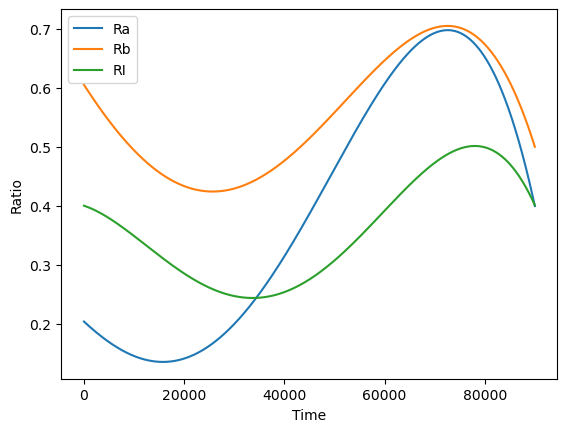

Creating plot.


In [40]:
IZH_inh_modified(e_in=0.25, save_output=True, output_file='fit_tests/modified_model_e25.png')

### Alcohol Inhibition (Complex, Modified 2)

In [63]:
# total run duration 90s
# desired quiescent 10s
# desired bimodal 25s
# desired tonic 15s

def IZH_inh_modified2(
    fI='int(t>100*ms)*10', 
    V=-65, 
    tau=0.25, 
    duration_t=5000,
    duration_b=7000,
    duration_q=8000,
    plot_colored=False, #True,
    e_in=0, 
    e_max=0.45,
    Ra=0,
    Rb=0,
    RI=0,
    save_output=False,
    output_file='test.png',
):
        
    defaultclock.dt = tau*ms
    tau = tau/ms
    
    eqs = '''
    dv/dt = int(t>duration/10)*tau*(0.04*v**2+5*v+140-u+((1-RI*(e_in/e_max))*I)) : 1
    du/dt = int(t>duration/10)*tau*((1-Ra*(e_in/e_max))*a)*(((1-Rb*(e_in/e_max))*b)*v-u) : 1
    I : 1
    '''

    # Create a NeuronGroup with one neuron using previous equations
    G = NeuronGroup(1, eqs, threshold='v>=30', reset='v=c; u+=d', method='euler')
    G.v = V
    G.u = 0.2*V
    
    M = StateMonitor(G, ('v', 'u', 'I'), record=0)
    
    @network_operation(dt=1*ms)
    def change_I():
        G.I = fI
    
    print(f'Running model...')
    a = 0.02
    b = 0.2
    c = -65
    d = 0.5 # ISI_tonic = 30ms
    
    Ra = 0.2
    Rb = 0.6
    RI = 0.4
    duration = 10000*ms
    run(duration)
    
    Ra = 0.1
    Rb = 0.4
    RI = 0.3
    duration = 10000*ms
    run(duration)
    
    Ra = 0.2
    Rb = 0.6
    RI = 0.4
    duration = 10000*ms
    run(duration)
    
    Ra = 0.1
    Rb = 0.4
    RI = 0.3
    duration = 20000*ms
    run(duration)
    
    Ra = 0.15
    Rb = 0.5
    RI = 0.35
    duration = 10000*ms
    run(duration)
    
    Ra = 0.2
    Rb = 0.6
    RI = 0.4
    duration = 20000*ms
    run(duration)
   
    # Plotting
    """
    plt.figure()
    plt.plot(M.t/ms, M.Ra[0], label='Ra')
    plt.plot(M.t/ms, M.Rb[0], label='Rb')
    plt.plot(M.t/ms, M.RI[0], label='RI')
    plt.xlabel('Time')
    plt.ylabel('Ratio')
    plt.legend()
    plt.show()"""
    
    print('Creating plot.')
    if plot_colored:
        plot_output_colored(M.t/ms, M.v[0], M.u[0], M.I[0], save_fig=save_output, file_name=output_file)
    else:
        plot_output_simple(M.t/ms, M.v[0], M.u[0], save_fig=save_output, file_name=output_file)
    


In [64]:
IZH_inh_modified2(e_in=0.25, save_output=True, output_file='fit_tests/modified2_model_e25.png')

Running model...
Creating plot.


In [65]:
inh_vals = [0.05, 0.10, 0.15, 0.20, 0.30, 0.35, 0.40, 0.45]

for val in inh_vals:
    print(f'Testing e = {val}')
    file = 'fit_tests/modified2_model_e' + str(int(100*val)) + '.png'
    IZH_inh_modified2(e_in=val, save_output=True, output_file=file)
    print('')
    
    

Testing e = 0.05
Running model...
Creating plot.

Testing e = 0.1
Running model...
Creating plot.

Testing e = 0.15
Running model...
Creating plot.

Testing e = 0.2
Running model...
Creating plot.

Testing e = 0.3
Running model...
Creating plot.

Testing e = 0.35
Running model...
Creating plot.

Testing e = 0.4
Running model...
Creating plot.

Testing e = 0.45
Running model...
Creating plot.

